In [ ]:
import pickle
import numpy as np
import pandas as pd
import networkx as nx
import matplotlib.pyplot as plt
import networkx.algorithms
import collections
import random
import itertools
import datetime
import networkx.algorithms.community as nxcom
#!pip install scipy==1.9.3 #run and then restart the kernel

In [ ]:
G = nx.Graph()
for i in range (63):
  st = "Graph_" + str(i)
  path = '/content/drive/MyDrive/day_graphs/'+st
  G_temp = pickle.load(open(path, 'rb'))
  G = nx.compose(G, G_temp)
  #print(G)

In [ ]:
#G = pickle.load(open('/content/drive/MyDrive/Graph_1','rb'))
attributes_dict = pickle.load(open('/content/drive/MyDrive/node_attributes','rb'))

In [ ]:
#nx.draw_networkx(G_test)

In [ ]:
nx.set_node_attributes(G, attributes_dict)

In [ ]:
#nx.write_gexf(G, "test.gexf")

#### Preprocessing

In [ ]:
#cleaning, throwing any entries that contain at least one empty values

#all attributes empty
completely_empty_nodes = [n for n, d in G.nodes(data=True) if not d]
#print(completely_empty_nodes)
G.remove_nodes_from(completely_empty_nodes)
#print(G)
#nx.write_gexf(G, "g_clean.gexf")

G.remove_edges_from(nx.selfloop_edges(G))


#### Exploratory Data Analysis

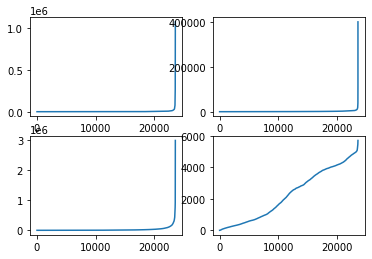

In [ ]:
#dataset characterization
fig, axs = plt.subplots(2, 2)
_ = axs[0,0].plot(sorted(list(nx.get_node_attributes(G, 'followers').values())))
_ = axs[0,1].plot(sorted(list(nx.get_node_attributes(G, 'following').values())))
_ = axs[1,0].plot(sorted(list(nx.get_node_attributes(G, 'total_tweets').values())))
_ = axs[1,1].plot(sorted(list(nx.get_node_attributes(G, 'twitter_age').values())))

In [ ]:
zeros = dict.fromkeys(list(attributes_dict.items())[0][1].keys(),0)
unknown = dict.fromkeys(list(attributes_dict.items())[0][1].keys(),0)

for key in zeros.keys():
  zeros[key] = collections.Counter(nx.get_node_attributes(G, key).values())[0]
print(zeros)

{'followers': 235, 'following': 293, 'total_tweets': 0, 'lists': 9679, 'twitter_age': 0, 'verified': 23561, 'party': 0}


#### Communities: Basics

In [ ]:
#k-cores

#2-core
G_core_2 = nx.k_core(G, 2)
print(G_core_2)
nx.write_gexf(G_core_2, "2_core.gexf")

#4-core
G_core_4 = nx.k_core(G, 4)
print(G_core_4)
nx.write_gexf(G_core_4, "4_core.gexf")

#7-core, max_core for day1
G_core_7 = nx.k_core(G, 7)
print(G_core_7)
nx.write_gexf(G_core_7, "7_core.gexf")

Graph with 15910 nodes and 218565 edges
Graph with 10521 nodes and 205893 edges
Graph with 7323 nodes and 190517 edges


#### Political Discourse on Twitter: Devoted Supporters, Partisanship and Gatekeeping

In [ ]:
#stepping into echo chambers

common_attr = 'party'
nodes_core = set()

for node in G_core_7.nodes():
  flag = True
  for neighbor in G_core_7.neighbors(node):
    if G_core_7.nodes[node][common_attr] != G_core_7.nodes[neighbor][common_attr]:
        flag = False
  if flag and len(list(G_core_7.neighbors(node))) > 2:
    G_core_7.nodes[node]['chamber'] = 1
  else:
    G_core_7.nodes[node]['chamber'] = 0
nx.write_gexf(G_core_7, "G_core_7_chambers.gexf")

##### Some more preprocessing

In [ ]:
sampled_nodes = []
t = 0.62 #balancing left/right

for node in G.nodes:
  if G.nodes[node]['party'] == 'left':
     p = random.random()
     if p < t:
       sampled_nodes.append(node)
  else:
    if G.nodes[node]['party'] == 'right':
      sampled_nodes.append(node)
    if G.nodes[node]['party'] == 'middle': #or G.nodes[node]['party'] == 'neutral':
      sampled_nodes.append(node)

G_sampled = G.subgraph(sampled_nodes)
#print(G, G_sampled)
G_sampled_core_2 = nx.k_core(G_sampled, 2)

In [ ]:
#tweeting rate (total_tweets/twitter_age), requires G to be preprocessed (clean)
for node in G.nodes:
  G.nodes[node]['tweeting_rate'] = G.nodes[node]['total_tweets']/G.nodes[node]['twitter_age']

for node in G_core_2:
  G_core_2.nodes[node]['tweeting_rate'] = G.nodes[node]['tweeting_rate']

for node in G_sampled_core_2:
  G_sampled_core_2.nodes[node]['tweeting_rate'] = G.nodes[node]['tweeting_rate']

In [ ]:
#approximate production/consumption using tweeting_rate

for node in G_sampled_core_2:
    G_sampled_core_2.nodes[node]['production_polarity'], G_sampled_core_2.nodes[node]['consumption_polarity']  = -1, -1

scoring_dict = {'left':0, 'middle':0.5, 'neutral':0.5, 'right':1}
for node in G_sampled_core_2.nodes:
  #print(node, G.nodes[node]['tweeting_rate'], list(G.neighbors(node)))
  temp = []
  production, consumption = [], []
  for neighbor in G_sampled_core_2.neighbors(node):
    #temp.append(G_sampled_core_2.nodes[neighbor]['party'])
    #print(G.nodes[node]['tweeting_rate'], G.nodes[neighbor]['tweeting_rate'])
    if (G_sampled_core_2.nodes[node]['tweeting_rate'] > G_sampled_core_2.nodes[neighbor]['tweeting_rate']):
      production.append(G_sampled_core_2.nodes[neighbor]['party'])
    else:
      consumption.append(G_sampled_core_2.nodes[neighbor]['party'])
  #print(production, consumption)
  #print(collections.Counter(production), collections.Counter(consumption))
  #print(collections.Counter(temp))

  for item in production:
    if len([scoring_dict[party] for party in production]) < 10: #robustness
      G_sampled_core_2.nodes[node]['production_polarity'] = -1
    else:
      G_sampled_core_2.nodes[node]['production_polarity'] = float(f'{sum([scoring_dict[party] for party in production])/len([scoring_dict[party] for party in production]):.3f}')
  for item in consumption:
    if len([scoring_dict[party] for party in consumption]) < 10: #robustness
      G_sampled_core_2.nodes[node]['consumption_polarity'] = -1
    else:
      G_sampled_core_2.nodes[node]['consumption_polarity'] = float(f'{sum ([scoring_dict[party] for party in consumption])/len([scoring_dict[party] for party in consumption]):.3f}')
  #print(production, G_sampled_core_2.nodes[node]['production_polarity'])
  #print(G_sampled_core_2.nodes[node]['production_polarity'], G_sampled_core_2.nodes[node]['consumption_polarity'])


##### Partisans, Consumers and Gatekeepers

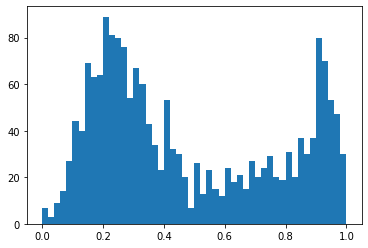

In [ ]:
delta = 0.3
partisans = []
nx.write_gexf(G_sampled_core_2, "mergedGraph_sampled_core_2.gexf")

for node in G_sampled_core_2:
  if G_sampled_core_2.nodes[node]['production_polarity'] >= 0:
    if min(G_sampled_core_2.nodes[node]['production_polarity'], 1-G_sampled_core_2.nodes[node]['production_polarity']) <= delta:
      partisans.append(node)
#print(partisans)

temp = nx.get_node_attributes(G_sampled_core_2, 'production_polarity').values()
#print(list(temp)[:100])
partisan_list = [item for item in temp if item >= 0]
_ = plt.hist(partisan_list, bins=50)

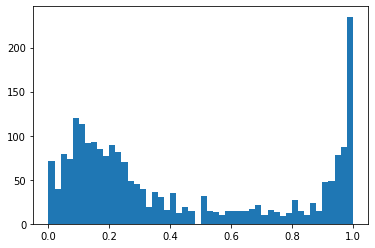

In [ ]:
#consumption
delta = 0.3

temp = nx.get_node_attributes(G_sampled_core_2, 'consumption_polarity').values()
partisan_list = [item for item in temp if item >= 0]
_ = plt.hist(partisan_list, bins=50)

In [ ]:
#gatekeeping

delta = 0.3
gatekeepers = []

for node in G_sampled_core_2:
  if (G_sampled_core_2.nodes[node]['production_polarity']>=0 and G_sampled_core_2.nodes[node]['consumption_polarity']>=0):
    if min(G_sampled_core_2.nodes[node]['production_polarity'],
         1-G_sampled_core_2.nodes[node]['production_polarity']) <= delta and min(G_sampled_core_2.nodes[node]['consumption_polarity'],
                                                                                 1 - G_sampled_core_2.nodes[node]['consumption_polarity']) > delta:
         gatekeepers.append(node)

print(gatekeepers)
#for node in gatekeepers:
  #print(G_sampled_core_2.nodes[node]['production_polarity'],G_sampled_core_2.nodes[node]['consumption_polarity'])

[202, 228, 248, 262, 283, 313, 354, 367, 373, 379, 433, 479, 648, 859, 883, 884, 1134, 1182, 1186, 1201, 1284, 1328, 1420, 1565, 1580, 1617, 1620, 1667, 1897, 2169, 2223, 2231, 2343, 2396, 2471, 2510, 2521, 2796, 2812, 2919, 3210, 3387, 3455, 3739, 3821, 4118, 4378, 4447, 4522, 5004, 5375, 6665, 6735, 7396, 7770, 7782, 8904, 9640, 12271, 13120, 15938]


In [ ]:
#metrics
#PageRank
pagerank = nx.pagerank(G, alpha=0.85)
page_g = sum(pagerank.values())/len(G)
core_2, part, gate = [], [], []
for user in G_sampled_core_2:
  core_2.append(pagerank[user])
page_core_2 = sum(core_2)/len(core_2)
for partisan in partisans:
  part.append(pagerank[partisan])
page_part = sum(part)/len(part)
for gatekeeper in gatekeepers:
  gate.append(pagerank[gatekeeper])
page_gate = sum(gate)/len(gate)

#clustering coefficient
cc_g = sum((nx.clustering(G)).values())/len(G)
cc_core_2 = sum((nx.clustering(G, sampled_nodes).values()))/len(sampled_nodes)
cc_part = sum((nx.clustering(G, partisans).values()))/len(partisans)
cc_gate = sum((nx.clustering(G, gatekeepers).values()))/len(gatekeepers)

#degrees
degrees = dict(G.degree)
deg_g = sum(degrees.values())/len(G.degree)
core, part, gate = [], [], []
for user in G_sampled_core_2:
  core_2.append(degrees[user])
deg_core_2 = sum(core_2)/len(core_2)
for partisan in partisans:
  part.append(degrees[partisan])
deg_part = sum(part)/len(part)
for gatekeeper in gatekeepers:
  gate.append(degrees[gatekeeper])
deg_gate = sum(gate)/len(gate)

avg_age_g = sum([G.nodes[node]['twitter_age'] for node in G.nodes])/len(G)
avg_age_core_2 = sum(G.nodes[node]['twitter_age'] for node in sampled_nodes)/len(sampled_nodes)
avg_age_part = sum(G.nodes[node]['twitter_age'] for node in partisans)/len(partisans)
avg_age_gate = sum(G.nodes[node]['twitter_age'] for node in gatekeepers)/len(gatekeepers)

avg_followers_g = sum([G.nodes[node]['followers'] for node in G.nodes])/len(G)
avg_followers_core_2 = sum([G.nodes[node]['followers'] for node in sampled_nodes])/len(sampled_nodes)
avg_followers_part = sum([G.nodes[node]['followers'] for node in partisans])/len(partisans)
avg_followers_gate = sum(G.nodes[node]['followers'] for node in gatekeepers)/len(gatekeepers)



df = pd.DataFrame(np.array([[page_g, page_core_2, page_part, page_gate],
                            [cc_g, cc_core_2, cc_part, cc_gate],
                            [deg_g, deg_core_2, deg_part, deg_gate],
                            [avg_followers_g, avg_followers_core_2, avg_followers_part, avg_followers_gate],
                            [avg_age_g, avg_age_core_2, avg_age_part, avg_age_gate]]),
                  columns = ['G', '2-core', 'partisans', 'gatekeepers'])
df.index = ['PageRank', 'clustering coefficient', 'degree', 'followers', 'age on Twitter']

display(df)

,G,2-core,partisans,gatekeepers
PageRank,0.000042,0.000067,0.000263,0.000257
clustering coefficient,0.197702,0.202224,0.173633,0.158907
degree,19.130913,16.147668,136.998445,135.540984
followers,2135.271431,2448.339657,8039.614308,20887.065574
age on Twitter,2278.255479,2378.521942,2307.411353,2877.032787


#### Dynamic Communities

In [ ]:
sampling_rate = 0.05
G_dynamic, G_prev = nx.Graph(), nx.Graph()

for i in range (63):
  p = random.random()
  if p < sampling_rate:
    st = "Graph_" + str(i)
    path = '/content/drive/MyDrive/day_graphs/'+st
    G_temp = pickle.load(open(path, 'rb'))
    G_temp.remove_edges_from(nx.selfloop_edges(G_temp))
    for node in G_temp.nodes:
      G_temp.nodes[node]['end_date'] = str(datetime.date(2022, 7, 26) + datetime.timedelta(days=63)) #timestamp
      if node not in G_prev:
        G_temp.nodes[node]['start_date'] = str(datetime.date(2022, 7, 25) + datetime.timedelta(days=i)) #timestamp
      if node in G_prev and node not in G_temp:
        G_temp.nodes[node]['end_date'] = str(datetime.date(2022, 7, 26) + datetime.timedelta(days=i)) #timestamp
    print("temp: ", G_temp)
    nx.set_node_attributes(G_temp, attributes_dict)
    G_dynamic = nx.compose(G_dynamic, G_temp)
    print("total: ", G_dynamic)
    G_prev = G_temp
G_dynamic = nx.k_core(G_dynamic, 2)
print(G_dynamic)

#modularity
communities = nxcom.greedy_modularity_communities(G_dynamic, resolution = 0.5)
for i, community in enumerate(communities):
    for node in community:
        G_dynamic.nodes[node]['community'] = i
path_write = "G_dynamic_sampled.gexf"
nx.write_gexf(G_dynamic, path_write)

temp:  Graph with 781 nodes and 1571 edges
total:  Graph with 781 nodes and 1571 edges
temp:  Graph with 1979 nodes and 3287 edges
total:  Graph with 2364 nodes and 4720 edges
temp:  Graph with 2827 nodes and 5719 edges
total:  Graph with 4112 nodes and 9956 edges
temp:  Graph with 2506 nodes and 5584 edges
total:  Graph with 5242 nodes and 15023 edges
temp:  Graph with 1278 nodes and 2082 edges
total:  Graph with 5574 nodes and 16763 edges
Graph with 2924 nodes and 14206 edges


In [ ]:
d = datetime.date(2022, 7, 25)
print(d)

d = d + datetime.timedelta(days = 18)
print(d)

2022-07-25
2022-08-12


In [ ]:
G_test = pickle.load(open('/content/drive/MyDrive/Graph_1','rb'))
G_test.remove_edges_from(nx.selfloop_edges(G_test))
G_test = nx.k_core(G_test, 2)
communities = nxcom.greedy_modularity_communities(G_test, resolution=1)
print(len(communities))


12


In [ ]:
nx.number_connected_components(G_test)

#### Tales of Modularity

Graph with 10 nodes and 28 edges


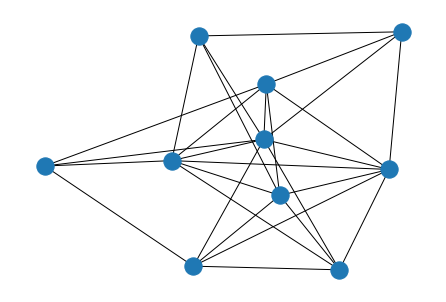

In [ ]:
G_random = nx.fast_gnp_random_graph(10, 0.7)
print(G_random)
nx.draw(G_random)

In [ ]:
from networkx.algorithms.community.modularity_max import greedy_modularity_communities
from networkx.algorithms.community.louvain import modularity

comms = greedy_modularity_communities(G_random)
print(comms)

[frozenset({0, 2, 3, 4, 5, 6, 7}), frozenset({8, 1, 9})]
